<a href="https://colab.research.google.com/github/arpitabhagat20/Data-Science/blob/main/META_Stock_GARCH_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from math import sqrt
import scipy.stats as ss
import scipy.optimize as opt
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from pandas_datareader import DataReader
from sklearn.metrics import mean_squared_error

In [ ]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,12,8)

META = yf.download('META', start_date, end_date)
META.reset_index(inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
META.describe()

,Open,High,Low,Close,Adj Close,Volume
count,991.000000,991.000000,991.000000,991.000000,991.000000,9.910000e+02
mean,247.751211,251.483320,244.302694,247.917942,247.917942,2.538646e+07
std,70.628923,70.925731,70.109156,70.540628,70.540628,1.645835e+07
min,90.080002,90.459999,88.089996,88.910004,88.910004,5.467500e+06
25%,192.610001,196.915001,187.799995,191.894997,191.894997,1.638040e+07
50%,258.279999,262.649994,254.820007,256.839996,256.839996,2.159120e+07
75%,307.329987,311.854996,302.494995,306.970001,306.970001,2.932915e+07
max,381.679993,384.329987,378.809998,382.179993,382.179993,2.323166e+08


In [ ]:
META['Typical_Price'] = META[['High', 'Low', 'Close']].mean(axis = 1)
META['lRETS'] = (np.log(META.Close) - np.log(META.Close.shift(1))) * 100.
META.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Typical_Price,lRETS
0,2020-01-02,206.750000,209.789993,206.270004,209.779999,209.779999,12077100,208.613332,NaN
1,2020-01-03,207.210007,210.399994,206.949997,208.669998,208.669998,11188400,208.673330,-0.530531
2,2020-01-06,206.699997,212.779999,206.520004,212.600006,212.600006,17058900,210.633336,1.865845
3,2020-01-07,212.820007,214.580002,211.750000,213.059998,213.059998,14912400,213.130000,0.216131
4,2020-01-08,213.000000,216.240005,212.610001,215.220001,215.220001,13475000,214.690002,1.008696


<ipython-input-18-ee0ffc7e2000>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(META['lRETS'].dropna(), ax = axes[0])


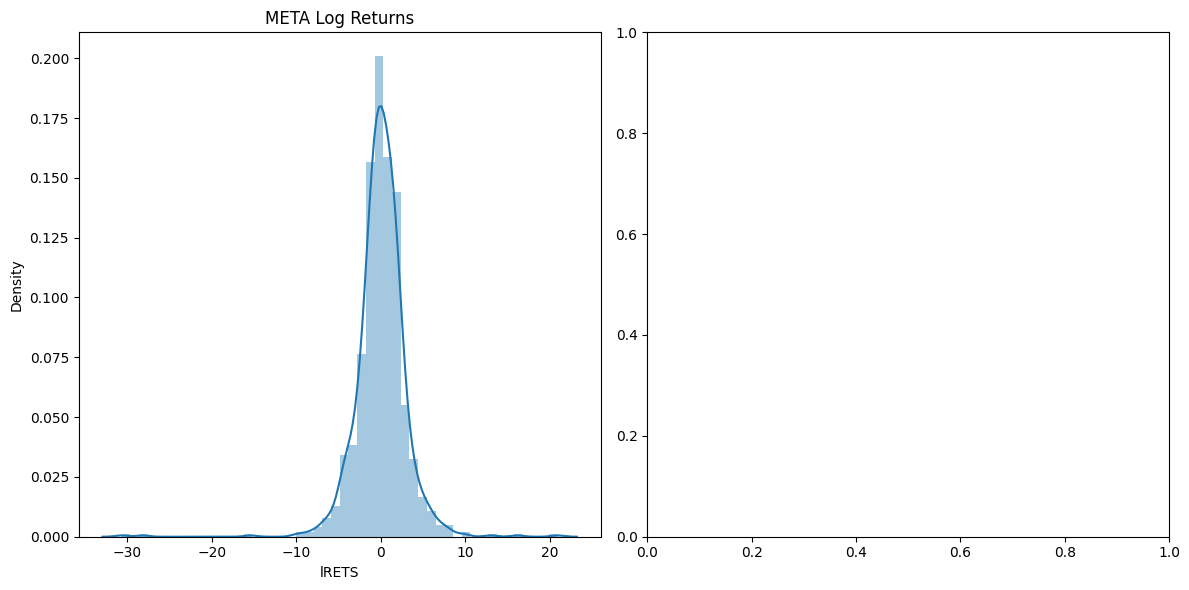

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 6))

sns.distplot(META['lRETS'].dropna(), ax = axes[0])
axes[0].set_title('META Log Returns')

plt.tight_layout()
plt.show()

Defining the GARCH Model and Likelihood Function:

In [ ]:
def GARCH(Y):
    "Initialize Params:"
    mu = param0[0]
    omega = param0[1]
    alpha = param0[2]
    beta = param0[3]
    T = Y.shape[0]
    GARCH_Dens = np.zeros(T)
    sigma2 = np.zeros(T)
    F = np.zeros(T)
    v = np.zeros(T)
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        F[t] = Y[t] - mu-np.sqrt(sigma2[t])*np.random.normal(0,1,1)
        v[t] = sigma2[t]
        GARCH_Dens[t] = (1/2)*np.log(2*np.pi)+(1/2)*np.log(v[t])+(1/2)*(F[t]/v[t])
        Likelihood = np.sum(GARCH_Dens[1:-1])
    return Likelihood

In [ ]:
def GARCH_Prod(params, Y0, T):
    mu = params[0]
    omega = params[1]
    alpha = params[2]
    beta = params[3]
    Y = np.zeros(T)
    sigma2 = np.zeros(T)
    Y[0] = Y0
    sigma2[0] = 0.0001
    for t in range(1,T):
        sigma2[t] = omega + alpha*((Y[t-1]-mu)**2)+beta*(sigma2[t-1]);
        Y[t] = mu+np.sqrt(sigma2[t])*np.random.normal(0,1,1)
    return Y

<ipython-input-21-368f47cb8073>:5: OptimizeWarning: Unknown solver options: xtol
  param_star = opt.minimize(GARCH, param0, method ='BFGS' , options = {'xtol' : 1e-8, 'disp' : True})
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 0.437848
         Iterations: 2
         Function evaluations: 127
         Gradient evaluations: 23


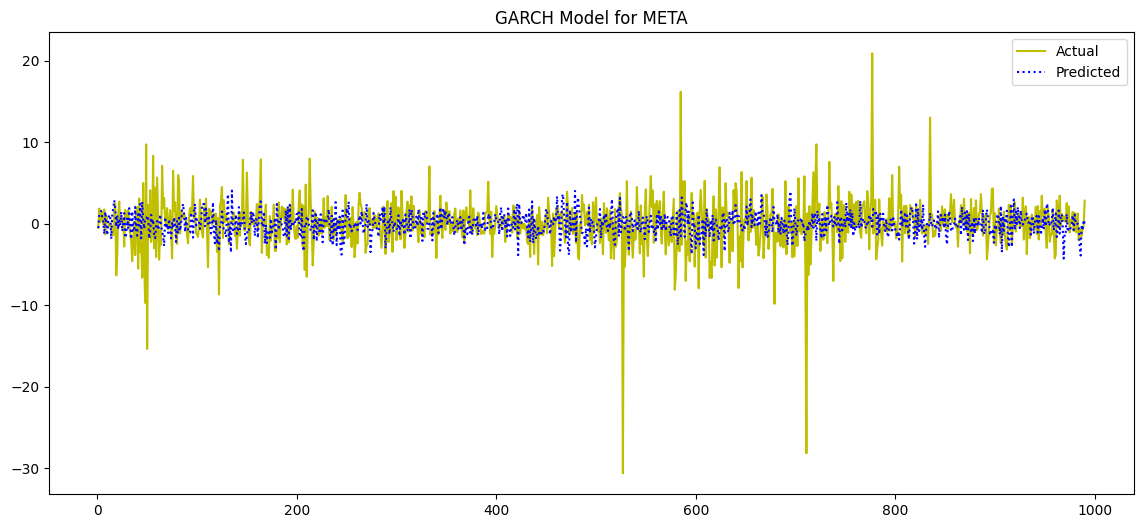

In [ ]:
Y = META['lRETS'].dropna()
T = len(Y)

param0 = np.array([0.1, 0.6, 0.15, 0.5])
param_star = opt.minimize(GARCH, param0, method ='BFGS' , options = {'xtol' : 1e-8, 'disp' : True})

Y_GARCH = GARCH_Prod(param_star.x, Y[1], T)
timevec = np.linspace(1, T, T)

fig = plt.figure(figsize = (14, 6))
plt.plot(timevec, Y, 'y-', label = 'Actual')
plt.plot(timevec, Y_GARCH, 'b:', label = 'Predicted')

plt.legend(loc = 'upper right')
plt.title("GARCH Model for META")
plt.show()

In [ ]:
GARCH_META = pd.DataFrame({'Actual':list(Y), 'Predicted':list(Y_GARCH)})
GARCH_META

,Actual,Predicted
0,-0.530531,-0.530531
1,1.865845,1.232478
2,0.216131,1.414132
3,1.008696,1.577381
4,1.420951,0.746532
...,...,...
985,-0.714756,-3.904609
986,-1.488775,-0.096686
987,-0.542052,-0.813511
988,-0.264258,0.475700


In [ ]:
RMS_META = sqrt(mean_squared_error(GARCH_META['Actual'], GARCH_META['Predicted']))
RMS_META

3.2901630161942736

In [ ]:
y_pred = [] * 1000

for i in range(len(GARCH_META)+1):
    if i == 0:
        y_pred.append(math.exp(GARCH_META['Predicted'][i]/100) * META['Close'][i])
    else:
        y_pred.append(math.exp(GARCH_META['Predicted'][i-1]/100) * META['Close'][i-1])

In [ ]:
META_Pred = pd.DataFrame({'Actual_Close_Price': META['Close'], 'Predicted_Close_Price': list(y_pred), 'Date': META.index})
META_Pred.set_index('Date', inplace = True)

In [ ]:
META_Pred

,Actual_Close_Price,Predicted_Close_Price
Date,,
0,209.779999,208.669998
1,208.669998,208.669998
2,212.600006,211.257724
3,213.059998,215.627809
4,215.220001,216.447411
...,...,...
986,324.820007,314.622237
987,320.019989,324.506102
988,318.290009,317.427152


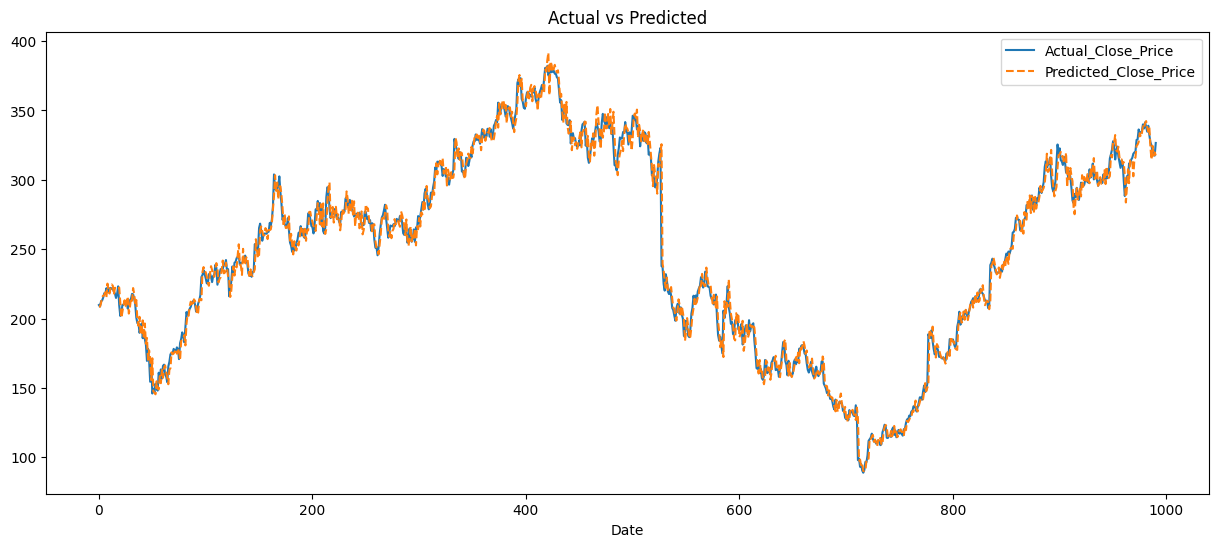

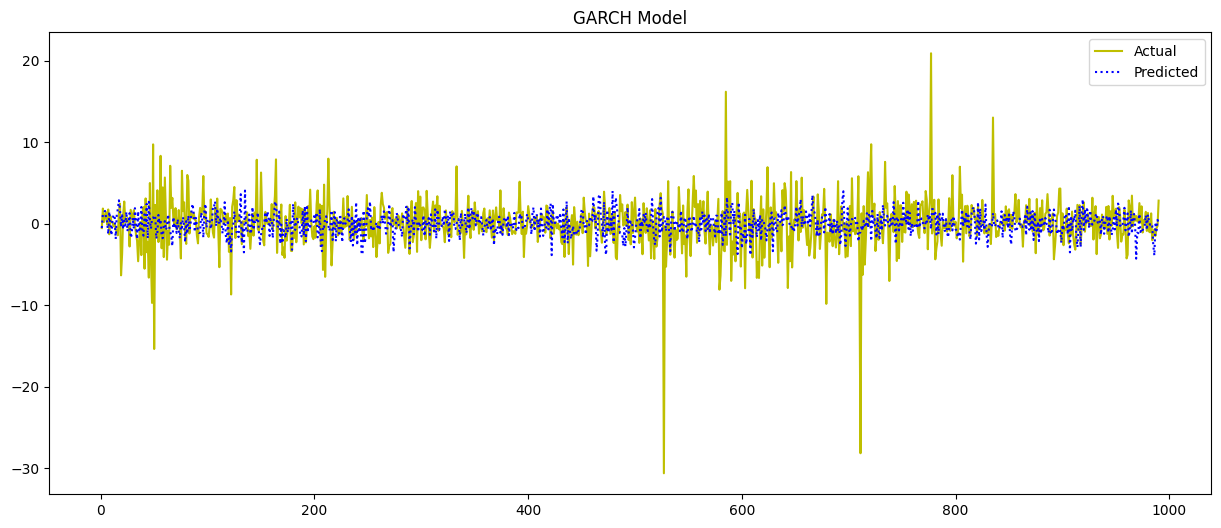

In [ ]:
META_Pred[['Actual_Close_Price', 'Predicted_Close_Price']].loc[:].plot(figsize = (15, 6), style = ['-', '--'], title = 'Actual vs Predicted')
fig = plt.figure(figsize = (15, 6))
plt.plot(timevec, Y, 'y-', label = 'Actual')
plt.plot(timevec, Y_GARCH, 'b:', label = 'Predicted')
plt.legend(loc = 'upper right')
plt.title("GARCH Model")
plt.show()

Trading Strategy



In [ ]:
signal = 0
amount = 10000
Amount = []
balance = 0
action = []
portfolio = 0
Portfolio = []
stocks = 0
Stocks = []


for i in range(len(META_Pred)-1):
    if META_Pred['Predicted_Close_Price'][i+1] > META_Pred['Actual_Close_Price'][i]:
        if signal == 0:
            action.append('Buy')
            stocks = int(amount / META_Pred['Actual_Close_Price'][i])
            balance = int(amount % META_Pred['Actual_Close_Price'][i])
            portfolio = stocks * META_Pred['Actual_Close_Price'][i]
            signal = 1
            amount = portfolio + balance
            print('Stock:', META_Pred['Actual_Close_Price'][i] , 'Action:', action[i], 'Portfolio:', round(portfolio,2), 'Stocks:', stocks, 'Balance_init:', balance, 'Total($)', round(amount,2))
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)
        else:
            action.append('Bought--Holding')
            portfolio = stocks * META_Pred['Actual_Close_Price'][i]
            amount = portfolio + balance
            print('Stock:', META_Pred['Actual_Close_Price'][i], 'Action:',action[i], 'Portfolio:', round(portfolio,2), 'Stocks:', stocks, 'Balance_init:', balance, 'Total($)', round(amount,2))
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)

    elif META_Pred['Predicted_Close_Price'][i+1] < META_Pred['Actual_Close_Price'][i]:
        if signal == 1:
            action.append('Sell')
            portfolio = stocks * META_Pred['Actual_Close_Price'][i]
            signal = 0
            stocks = 0
            amount = balance + portfolio
            portfolio = 0
            balance = 0
            print('Stock:', META_Pred['Actual_Close_Price'][i], 'Action:', action[i], 'Portfolio:', round(portfolio,2), 'Stocks:', stocks, 'Balance_init:', balance, 'Total($)', round(amount,2))
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)
        else:
            action.append('Price-Prediction-Already-Lower')
            print('Stock:',META_Pred['Actual_Close_Price'][i], 'Action:', action[i], 'Portfolio:', round(portfolio,2), 'Stocks:', stocks, 'Balance_init:', balance, 'Total($)', round(amount,2))
            Portfolio.append(round(portfolio, 5))
            Amount.append(round(amount, 0))
            Stocks.append(stocks)

    print('\n')

Stock: 209.77999877929688 Action: Price-Prediction-Already-Lower Portfolio: 0 Stocks: 0 Balance_init: 0 Total($) 10000


Stock: 208.6699981689453 Action: Buy Portfolio: 9807.49 Stocks: 47 Balance_init: 192 Total($) 9999.49


Stock: 212.60000610351562 Action: Bought--Holding Portfolio: 9992.2 Stocks: 47 Balance_init: 192 Total($) 10184.2


Stock: 213.05999755859375 Action: Bought--Holding Portfolio: 10013.82 Stocks: 47 Balance_init: 192 Total($) 10205.82


Stock: 215.22000122070312 Action: Bought--Holding Portfolio: 10115.34 Stocks: 47 Balance_init: 192 Total($) 10307.34


Stock: 218.3000030517578 Action: Bought--Holding Portfolio: 10260.1 Stocks: 47 Balance_init: 192 Total($) 10452.1


Stock: 218.05999755859375 Action: Sell Portfolio: 0 Stocks: 0 Balance_init: 0 Total($) 10440.82


Stock: 221.91000366210938 Action: Buy Portfolio: 10429.77 Stocks: 47 Balance_init: 11 Total($) 10440.77


Stock: 219.05999755859375 Action: Bought--Holding Portfolio: 10295.82 Stocks: 47 Balance_init: 11 Tot

In [ ]:
Strategy_Result = pd.DataFrame({'Actual_Close_Price': META['Close'][1:],
                               'Predicted_Close_Price': list(y_pred[1:]),
                               'Date': META.index[1:],
                               'Action': action,
                               'Amount($)':Amount,
                               'Portfolio($)': Portfolio,
                               'Stocks': Stocks})

Strategy_Result.head()

,Actual_Close_Price,Predicted_Close_Price,Date,Action,Amount($),Portfolio($),Stocks
1,208.669998,208.669998,1,Price-Prediction-Already-Lower,10000.0,0.00000,0
2,212.600006,211.257724,2,Buy,9999.0,9807.48991,47
3,213.059998,215.627809,3,Bought--Holding,10184.0,9992.20029,47
4,215.220001,216.447411,4,Bought--Holding,10206.0,10013.81989,47
5,218.300003,216.832700,5,Bought--Holding,10307.0,10115.34006,47


<Axes: title={'center': 'Total Amount'}>

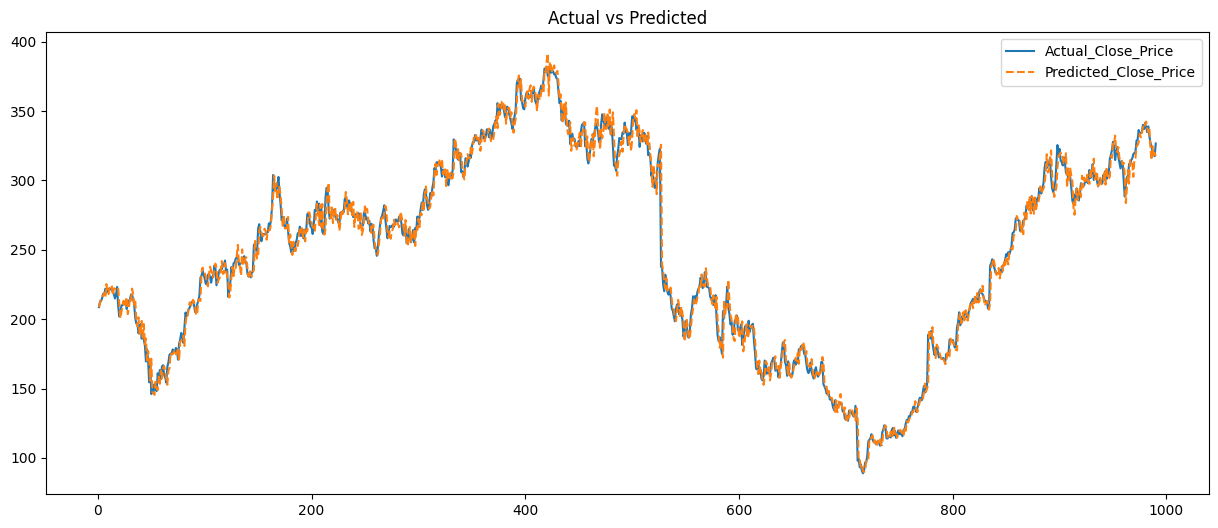

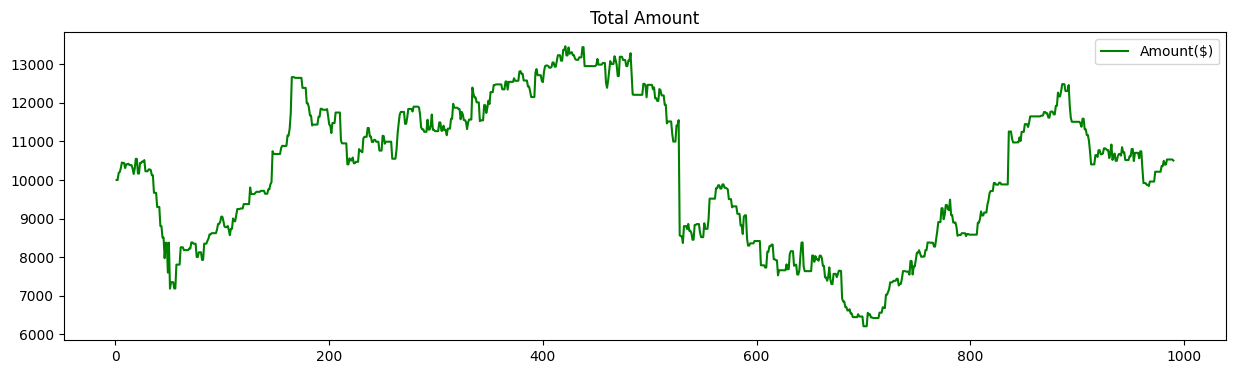

In [ ]:
Strategy_Result[['Actual_Close_Price', 'Predicted_Close_Price']].loc[:].plot(figsize = (15, 6), style = ['-', '--'], title = 'Actual vs Predicted')
Strategy_Result[['Amount($)']].iloc[0:].plot(figsize = (15, 4), style = ['-g'], title = 'Total Amount')

In [ ]:
Profit = (Amount[-1] / 10000) - 1  # Assuming Amount[-1] represents the final amount
Profit_percent = Profit * 100

print('Initial Investment: $10,000')
print('Final Amount:', Amount[-1], '$')
print('Profit Percentage:', Profit_percent, '%')

Initial Investment: $10,000
Final Amount: 10502.0 $
Profit Percentage: 5.020000000000002 %
